<a href="https://colab.research.google.com/github/F-Yousefi/Getting-Started-with-Pytorch/blob/main/Getting_Started_With_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started with Pytorch
## **_Mnist Dataset_**
###Prerequisites:
------
In this project, Pytorch Lightning is utilized because it is easy to use and help us write less and save more time. It is not installed in Google Colab in default. As a consequence, we need to download and install it. It is our first step to take.

In [ ]:
!pip install lightning

### Libraries
------------
In this project, the libraries listed below are used.

In [2]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.transforms import v2
import numpy as np
import matplotlib.pyplot as plt
import lightning as ltorch
import torchmetrics

### Download Dataset:
---------
In the following cell, we are going to download mnist dataset. The key point in this cell is that we used the property called `transform`. Using this property, you can set what trasformations automatically apply to the dataset as you use the variable `train_data, test_data`.

In [3]:
train_data = MNIST(
    root= "data",
    train= True,
    download= True,
    transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
    )
test_data = MNIST(
    root= "data",
    train= False,
    download= True,
    transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
    )

### Data Agumentation
---------
In the next code cell, the train dataset is loaded. We will apply some transforms to it in order to increase the number of the samples. As a result, new dataset have a shape of `(120,000 x 28 x 28)`.

In [4]:
train_x, train_y = train_data.data, train_data.targets
data_agumentation= v2.Compose([
    v2.RandomZoomOut(fill=0, side_range=(1.08, 1.08), p= 0.5),
    v2.Resize(size=(28,28), antialias=False),
    v2.RandomRotation(degrees=(0,10)),
    v2.RandomResizedCrop(size= (28,28), scale=(0.9,0.9), antialias=False),
    v2.RandomPerspective(distortion_scale=0.4, p=0.50),
] )

additional_train_x = data_agumentation(train_x)

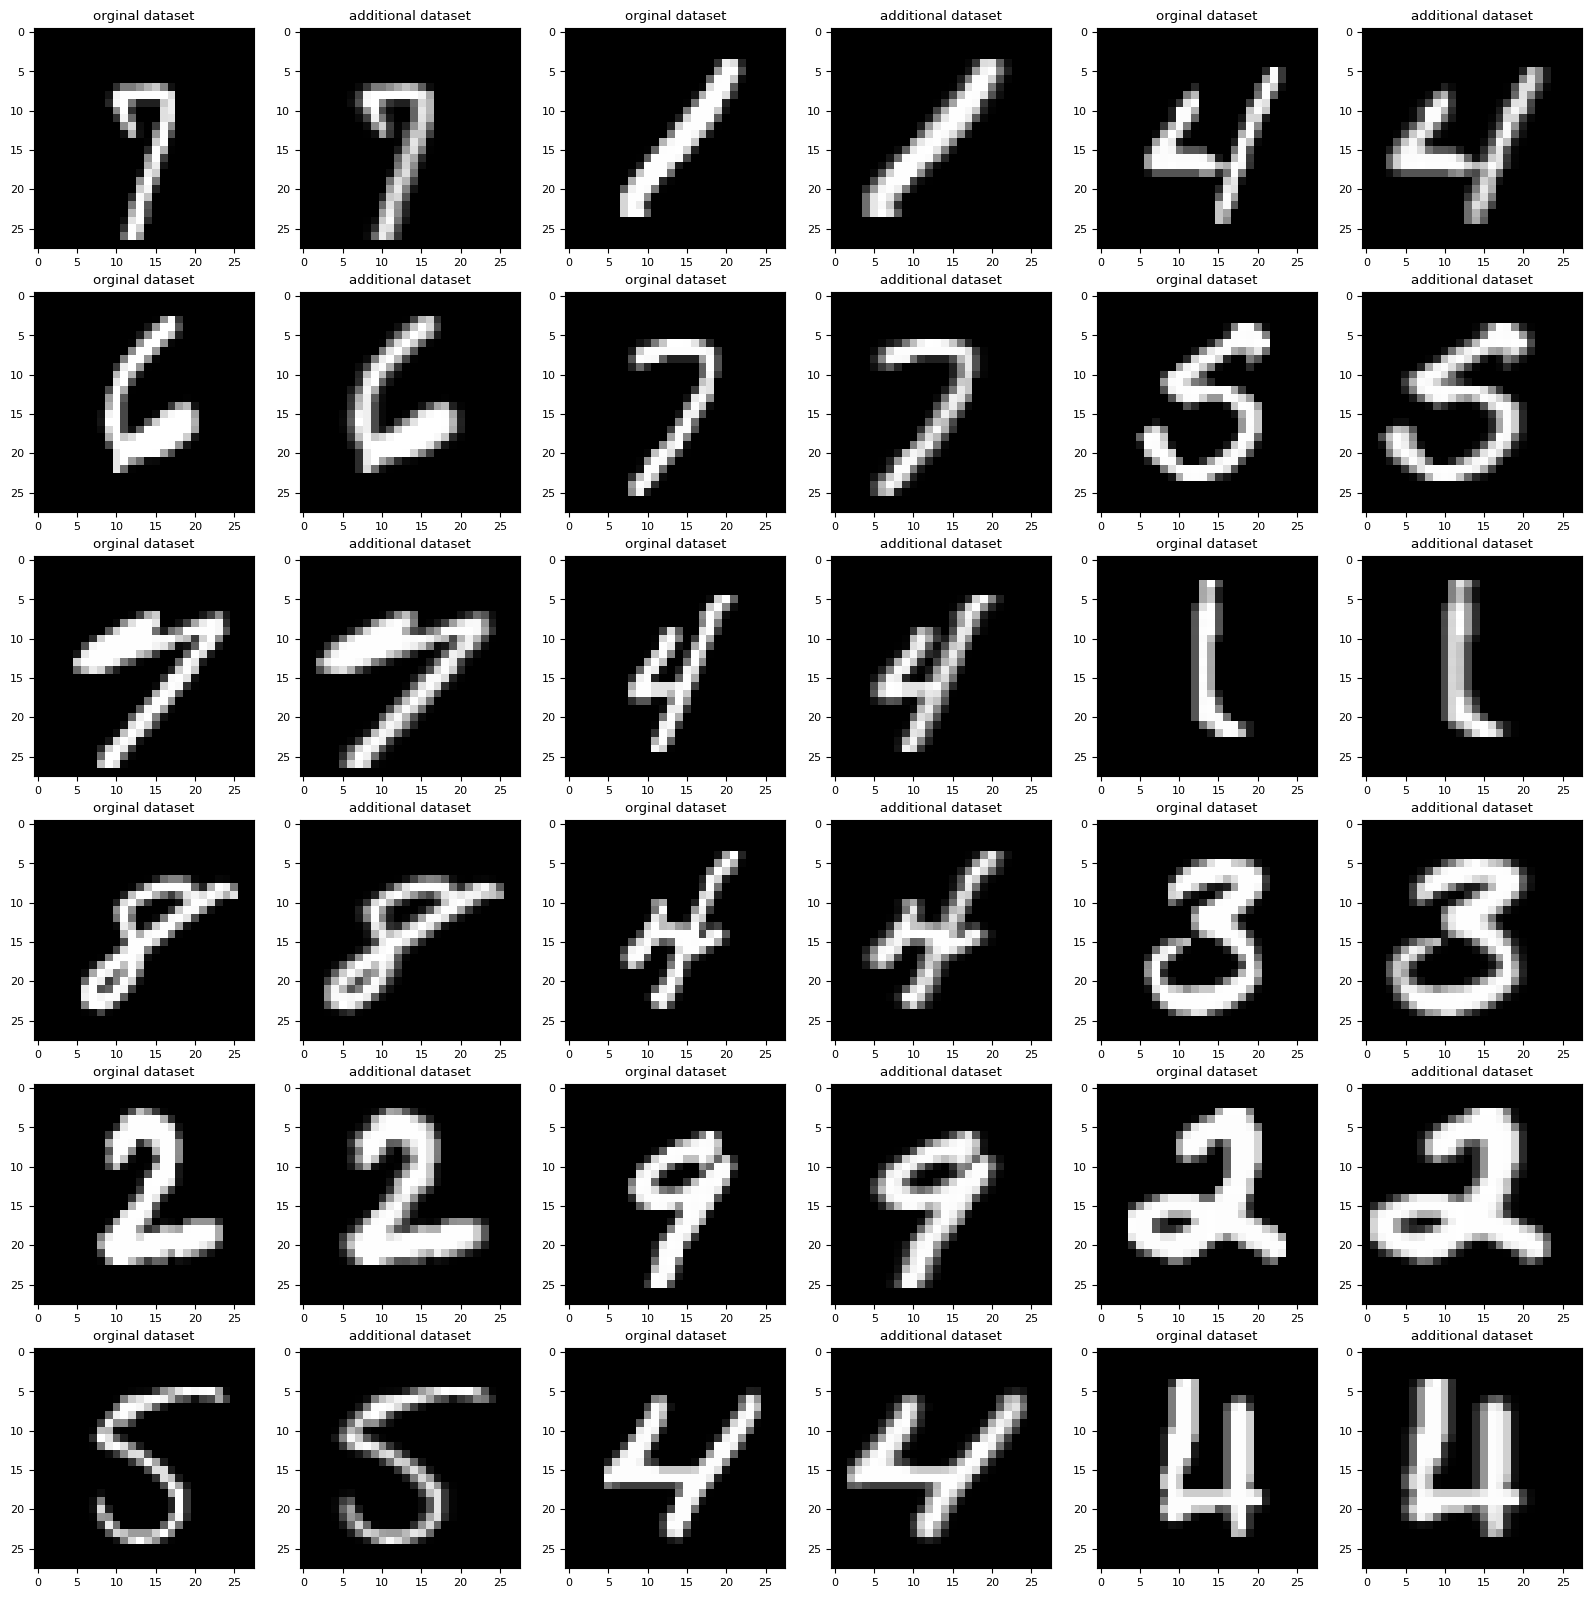

In [5]:
plt.rcParams.update({'font.size': 8})
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(20,20))
axes = axes.ravel()
samples = torch.randint(low= 0,high = 6000,size = (1,18)).tolist()[0]
i = 0
for idx,ax in enumerate(axes):
    if i % 2 ==0:
      ax.figure
      ax.imshow(train_x[samples[int(idx/2)]], cmap="gray")
      ax.set_title(f"orginal dataset")
    else:
      ax.figure
      ax.imshow(additional_train_x[samples[int(idx/2)]], cmap="gray")
      ax.set_title(f"additional dataset")
    i += 1


In [6]:
train_x = torch.cat([train_x, additional_train_x],dim=0)
train_x = torch.unsqueeze(train_x, 1)
train_x = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])(train_x)
train_y = torch.cat([train_y, train_y], dim=0)
print(f"the shape of the new dataset: {train_x.shape}")
del additional_train_x

the shape of the new dataset: torch.Size([120000, 1, 28, 28])


###Architecture
-------------
The model that we have used solve this problem is as follows. It is actually based on the article [MNIST: Keras Simple CNN (99.6%)](https://medium.com/@BrendanArtley/mnist-keras-simple-cnn-99-6-731b624aee7f) published by "Brendan Artley".

In [7]:

conv = lambda in_channels, out_channels, dropout:\
nn.Sequential(
    nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,3)),
    nn.ReLU(),
    nn.BatchNorm2d(num_features = out_channels),
    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3,3)),
    nn.ReLU(),
    nn.BatchNorm2d(num_features = out_channels),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
    nn.Dropout2d(p= dropout)
)

nn.Flatten(),
dense = lambda input_size, units: nn.Sequential(
    nn.Linear(input_size, out_features=units),
    nn.ReLU(),
    nn.BatchNorm1d(units),
    nn.Dropout1d(p=0.25),
)

class MnistClassifier(ltorch.LightningModule):
  def __init__(self):
    super().__init__()
    self.conv1 = conv(1,32,0.25)
    self.conv2 = conv(32,64,0.25)
    self.flatten = nn.Flatten(start_dim=1)
    self.dense1 = dense(1024, 512)
    self.dense2 = dense(512, 1024)
    self.classification = nn.Sequential(nn.Linear(1024,10), nn.Softmax(dim=-1))

  def training_step(self, batch, batch_idx):
    self.train()
    x, y = batch
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dense2(x)
    y_hat = self.classification(x)
    loss = nn.functional.cross_entropy(y_hat, y)
    acc = torchmetrics.functional.accuracy(y_hat, y, task = "multiclass", num_classes = 10)
    self.log_dict({"train_loss" : loss, "train_acc":acc }, on_step=True, on_epoch=True,prog_bar=True )
    return loss

  def validation_step(self, batch, batch_idx):
        self.eval()
        x, y = batch
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        y_hat = self.classification(x)
        loss = nn.functional.cross_entropy(y_hat, y)
        acc = torchmetrics.functional.accuracy(y_hat, y, task = "multiclass", num_classes = 10)
        self.log_dict({"val_loss" : loss, "val_acc":acc }, on_step=True, on_epoch=True,prog_bar=True )

  def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
      return optimizer


  def train_dataloader(self):
      return torch.utils.data.DataLoader(
      train_data,
      batch_size=256,
      shuffle=False,
      num_workers=2)


  def val_dataloader(self):
    return torch.utils.data.DataLoader(
        test_data,
        batch_size=256,
        shuffle=False,
        num_workers=2)

model = MnistClassifier()

In [8]:
train_data = torch.utils.data.TensorDataset((train_x),train_y)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1024, shuffle=True ,num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=256, shuffle=False,num_workers=2)

In [ ]:
trainer = ltorch.Trainer(max_epochs=5, accelerator="auto", devices="auto", strategy="auto")
trainer.fit(model=model)